In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import rtbm.layers as layers
import rtbm.model as mdl

import warnings
warnings.filterwarnings('ignore')

from rtbm.costfunctions import mse, crossentropy
from rtbm import minimizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

from scipy import signal

RTBM_precision= 1e-5

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Process PoolWorker-1:
Process PoolWorker-9:
Process PoolWorker-8:
Process PoolWorker-12:
Process PoolWorker-7:
Process PoolWorker-3:
Process PoolWorker-4:
Process PoolWorker-5:
Process PoolWorker-11:
Process PoolWorker-14:
Process PoolWorker-10:
Process PoolWorker-16:
Process PoolWorker-15:
Process PoolWorker-13:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-2:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib

# Example 1: Sine-Mixture with gaussian noise

In [2]:
def func(x,n):
    return 0.5*np.sin(1*x+0.1)+0.75*np.sin(0.25*x-0.3)+n*np.random.normal(0,0.2,x.shape[2])

X = np.linspace(0, 100, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

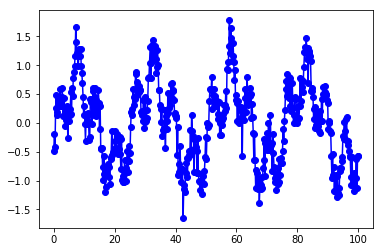

In [3]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [4]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,3,phase=1j))
M.add(layers.DiagExpectationUnitLayer(3,3,phase=1j))
M.add(layers.DiagExpectationUnitLayer(3,1,phase=1j))

In [5]:
minim = minimizer.CMA(parallel=False)
minim.train(mse(), M, X, Y, tolfun=1e-4)

CMA on 1 cpu(s) enabled
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 29 (seed=880940, Sat Nov  4 01:01:45 2017)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 2.299651990375991e-01 1.0e+00 9.29e-01  9e-01  9e-01 0:01.4
    2     28 2.299212612724596e-01 1.1e+00 8.83e-01  9e-01  9e-01 0:02.5
    3     42 2.297823867778782e-01 1.1e+00 8.91e-01  9e-01  9e-01 0:03.9
    6     84 2.283348740595906e-01 1.2e+00 9.21e-01  9e-01  9e-01 0:07.2
   10    140 2.293839854358762e-01 1.3e+00 9.86e-01  1e+00  1e+00 0:12.2
   13    182 2.285501185216046e-01 1.4e+00 1.04e+00  1e+00  1e+00 0:17.8
   17    238 2.192787542973938e-01 1.5e+00 1.09e+00  1e+00  1e+00 0:25.8
   21    294 2.266435814656492e-01 1.6e+00 1.14e+00  1e+00  1e+00 0:33.2
   27    378 2.295644192819095e-01 1.7e+00 1.11e+00  1e+00  1e+00 0:42.6
   34    476 2.289190114351742e-01 1.7e+00 9.85e-01  9e-01  1e+00 0:52.3
   42    588 2.295145107290310e-01 1.7e+00 1.00e+00  9e-01  1e+00 1:02.9
   49    

KeyboardInterrupt: 

In [ ]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"bo-", label='fit')
plt.legend()

In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,3))
M.add(layers.DiagExpectationUnitLayer(3,1))

minim = minimizer.SGD()
minim.train(mse(), M, X, Y, lr=0.0001, momentum=0.5,nesterov=True,noise=0.001, maxiter=2000)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.legend()

# Example 2: Sine-Cosine-Mixture with trend and gaussian noise

In [ ]:
def func(x,n):
    return 0.02*x+0.5*np.sin(1*x+0.1)+0.75*np.cos(0.25*x-0.3)+n*np.random.normal(0,0.2,x.shape[2])

X = np.linspace(0, 100, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

In [ ]:
Y = func(X[:,None],0).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"-")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("sincosmix.eps", format="eps")
plt.show()


In [ ]:
Y = func(X[:,None],1).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"-")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("sincosmix_noise.eps", format="eps")

plt.show()



In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,3))
M.add(layers.DiagExpectationUnitLayer(3,2))
M.add(layers.DiagExpectationUnitLayer(2,1))

In [ ]:
minim = minimizer.CMA(parallel=True)
minim.train(mse(), M, X, Y, tolfun=1e-4)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og", label='train')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"b-", label='fit', linewidth=5)
plt.legend()
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("sincosmix_10-4.eps", format="eps")
plt.show()

# Example: Intrawave modulation

In [ ]:
def func(x,n):
    return np.cos(0.01*x+0.5*np.cos(0.05*x))/(2+np.sin(0.04*x))

X = np.linspace(0, 1000, 1000)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"b-")

In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,5))
M.add(layers.DiagExpectationUnitLayer(5,5))
M.add(layers.DiagExpectationUnitLayer(5,3))
M.add(layers.DiagExpectationUnitLayer(3,1))

In [ ]:
minim = minimizer.CMA(parallel=True)
minim.train(mse(), M, X, Y, tolfun=1e-4)

In [ ]:
npoints = 1000
test_X = (np.linspace(0, 1000, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og", label='train')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"b-", label='fit', linewidth=5)
plt.legend()
plt.xlabel("t")
plt.ylabel("y")

# Example 3: Saw-tooth

In [ ]:
def func(x,n):
    return signal.sawtooth(x)

X = np.linspace(0, 30, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

In [ ]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,100))
minim = minimizer.CMA(parallel=True)
minim.train(mse(), M, X, Y, maxiter=100)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 30, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.xaxis("t")
plt.yaxis("y(t)")
plt.savefig("sawtooth_reg.eps", format="eps")
plt.legend()

# Example 3: MNIST (work in progress...)

In [ ]:
# Load MNIST dataset
MNIST_train = pd.read_csv('~/data/mnist_train.csv', delimiter=",",header=None).values
MNIST_test  = pd.read_csv('~/data/mnist_test.csv', delimiter=",",header=None).values

# Prepare data (normalized onto [0,1])
Y_train = MNIST_train[0:10000,0]
X_train = MNIST_train[0:10000,1:]/255.0

Y_test = MNIST_test[:,0]
X_test = MNIST_test[:,1:]/255.0

In [ ]:
M = mdl.Model()
#M.add(layers.Linear(784,1,paramBound=100))
M.add(layers.DiagExpectationUnitLayer(784,1,Qmax=5,paramBound=5))
#M.add(layers.DiagExpectationUnitLayer(784,10,Qmax=3,paramBound=5))
#M.add(layers.DiagExpectationUnitLayer(25,10,Qmax=3,paramBound=5))
#M.add(layers.DiagExpectationUnitLayer(10,1))
#M.add(layers.SoftMaxLayer(10))
#M.add(layers.MaxPosLayer(10,1))

#enc = LabelBinarizer()
#enc.fit(np.diag([1,1,1,1,1,1,1,1,1,1]))
#enc.classes_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#T=enc.transform(Y_train)


In [ ]:
minim = minimizer.CMA(True)

sol=minim.train(mse(), M, np.transpose(X_train), np.transpose(Y_train), maxiter=1000)

In [ ]:
#P=np.argmax(np.real(M.predict(np.transpose(X_train))),axis=0)
P=np.abs(np.round(np.real(M.predict(np.transpose(X_train)))))


print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))

In [ ]:
#P=np.argmax(np.real(M.predict(np.transpose(X_test))),axis=0)
P=np.abs(np.round(np.real(M.predict(np.transpose(X_test)))))


print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))